<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=145930577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    #ema_125 = df.ta.ema(125, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# Today's Top Gainers 
## Including Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, & Kalman Forecast Predictors

In [7]:
from datetime import datetime
today = pd.Timestamp(datetime.now()).strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2023-10-10.

## [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [16]:
!pip install fear-and-greed
clear_output()
import fear_and_greed
#type(fear_and_greed.get())
print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  29.6857142857143

Range:  fear

Datetime:  2023-10-10 00:00:00+00:00

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: VTSCY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 19.44499969482422

Ichimoku 9-Day Forecast: 17.332499504089355

Ichimoku 26-Day Forecast: 17.332499504089355

Choppiness (%): 28.23

RSI: 72.98141383755323

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

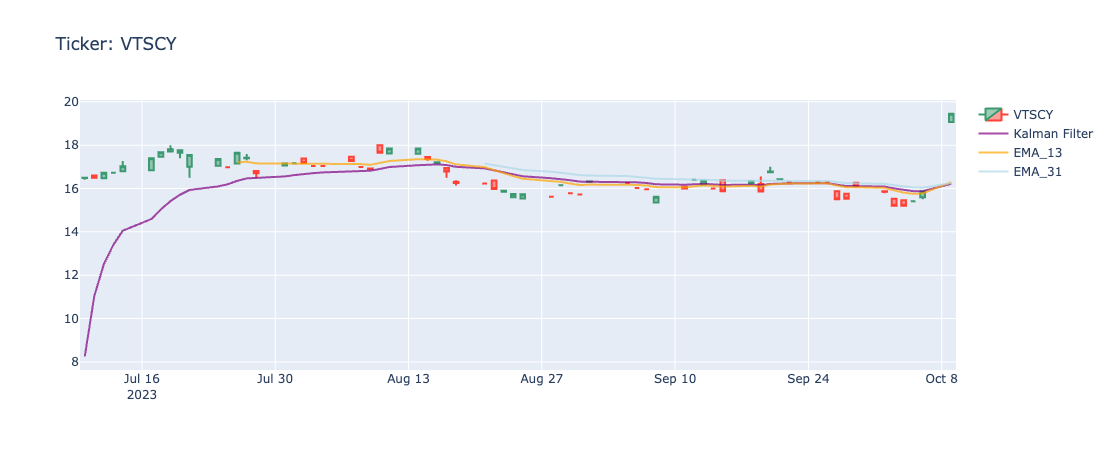

Ticker: NWTN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 9.0

Ichimoku 9-Day Forecast: 8.515000104904175

Ichimoku 26-Day Forecast: 8.900000095367432

Choppiness (%): 53.93

RSI: 54.56445607906895

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

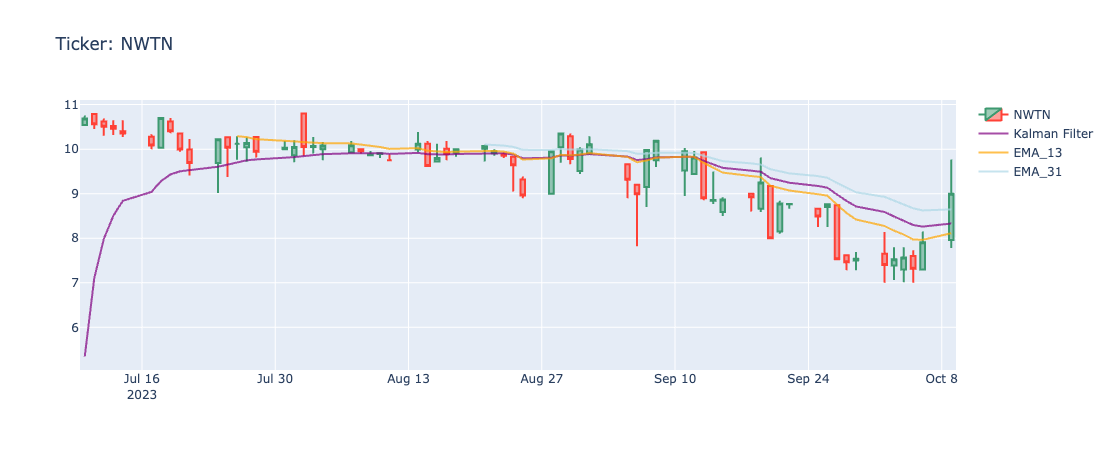

Ticker: NOC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 471.6099853515625

Ichimoku 9-Day Forecast: 444.52000427246094

Ichimoku 26-Day Forecast: 444.52000427246094

Choppiness (%): 36.56

RSI: 68.83155485066683

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

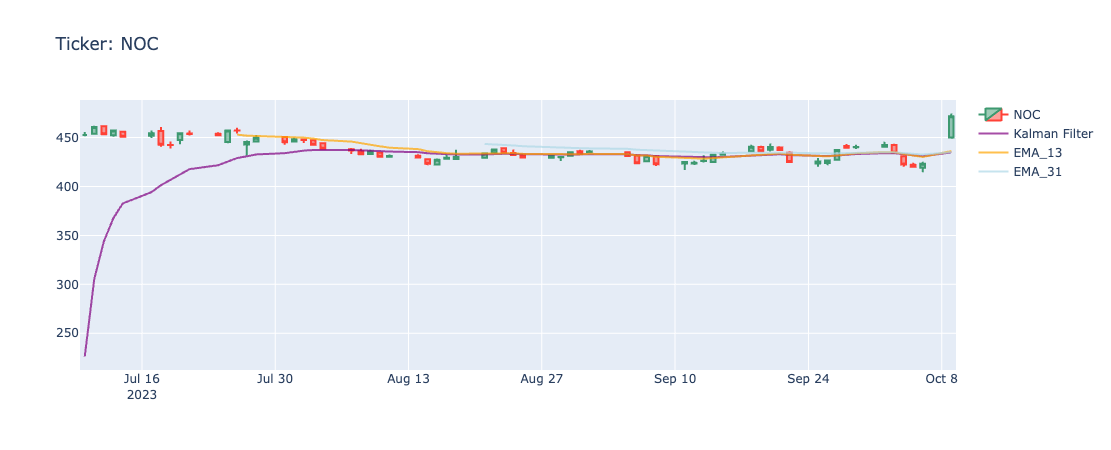

Ticker: KTOS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 16.809999465942383

Ichimoku 9-Day Forecast: 15.537499904632568

Ichimoku 26-Day Forecast: 15.644999504089355

Choppiness (%): 34.67

RSI: 73.21938773580516

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

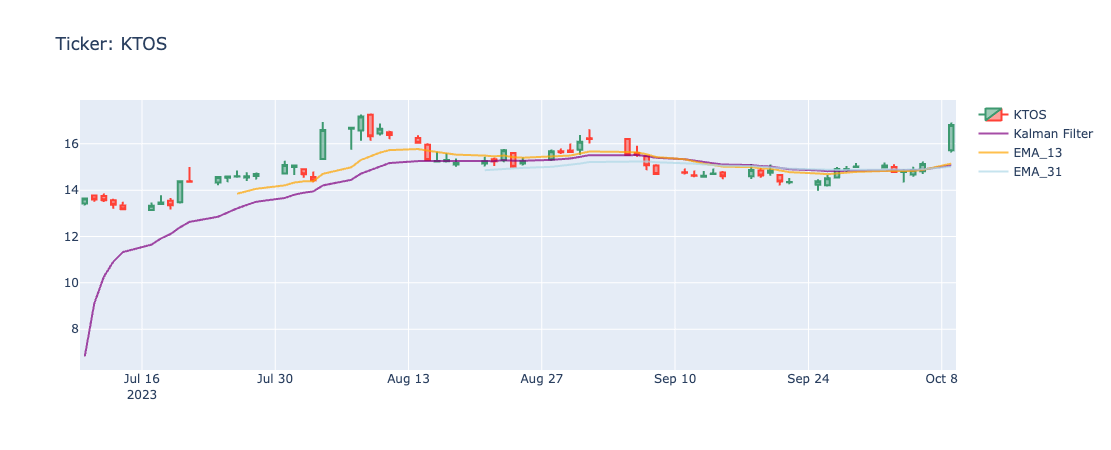

Ticker: LHX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 180.2100067138672

Ichimoku 9-Day Forecast: 170.41000366210938

Ichimoku 26-Day Forecast: 179.83499908447266

Choppiness (%): 40.15

RSI: 59.56783123576721

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

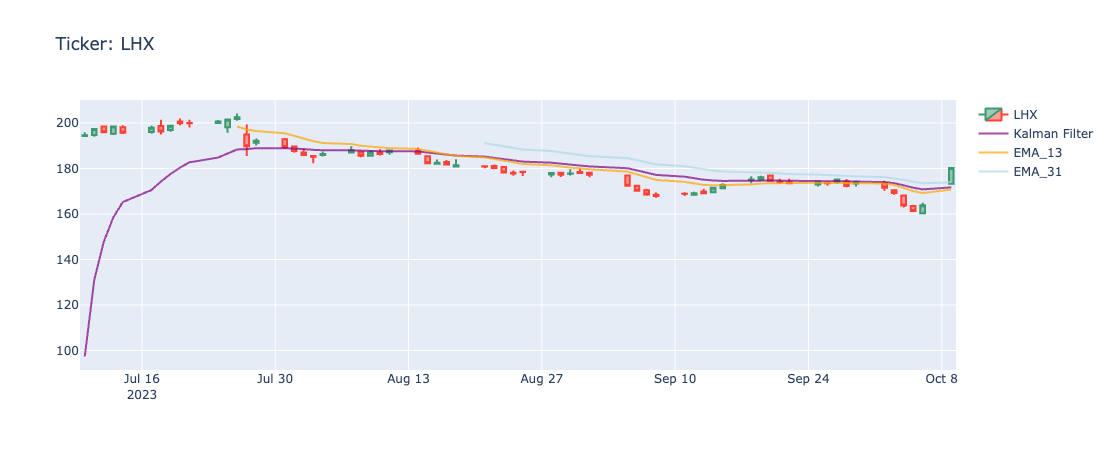

Ticker: HII

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 221.44000244140625

Ichimoku 9-Day Forecast: 210.5275001525879

Ichimoku 26-Day Forecast: 217.29000091552734

Choppiness (%): 39.37

RSI: 67.18454963018368

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

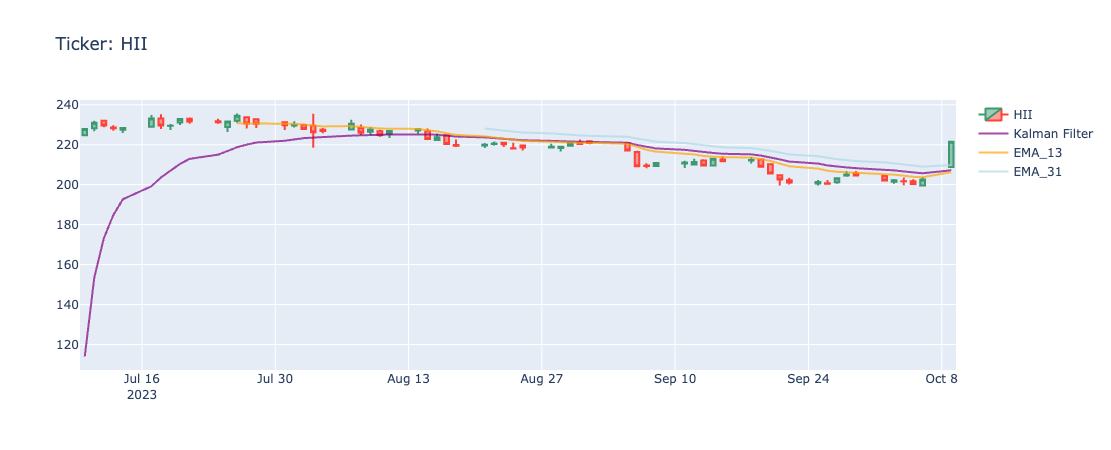

Ticker: CPE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 36.779998779296875

Ichimoku 9-Day Forecast: 36.89750003814697

Ichimoku 26-Day Forecast: 37.135000228881836

Choppiness (%): 41.56

RSI: 48.41100102841035

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

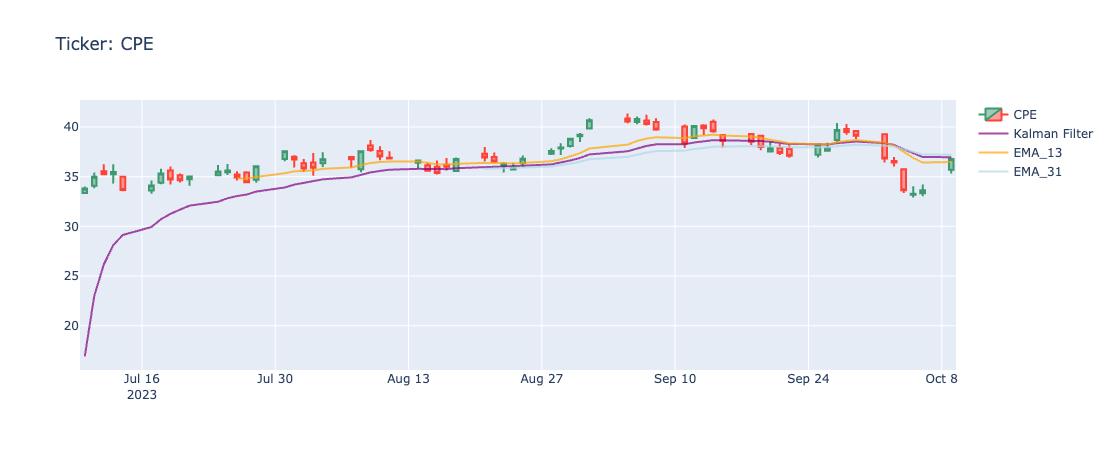

Ticker: LMT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 436.5299987792969

Ichimoku 9-Day Forecast: 419.0074996948242

Ichimoku 26-Day Forecast: 425.7200012207031

Choppiness (%): 35.00

RSI: 61.5313995238207

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

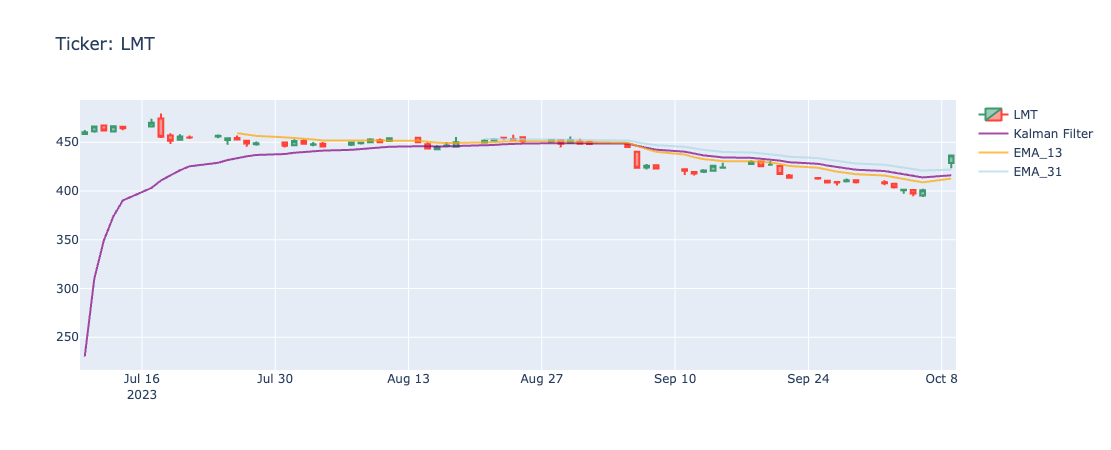

Ticker: GD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 238.47999572753906

Ichimoku 9-Day Forecast: 227.33999633789062

Ichimoku 26-Day Forecast: 227.33999633789062

Choppiness (%): 35.46

RSI: 70.05390285511254

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

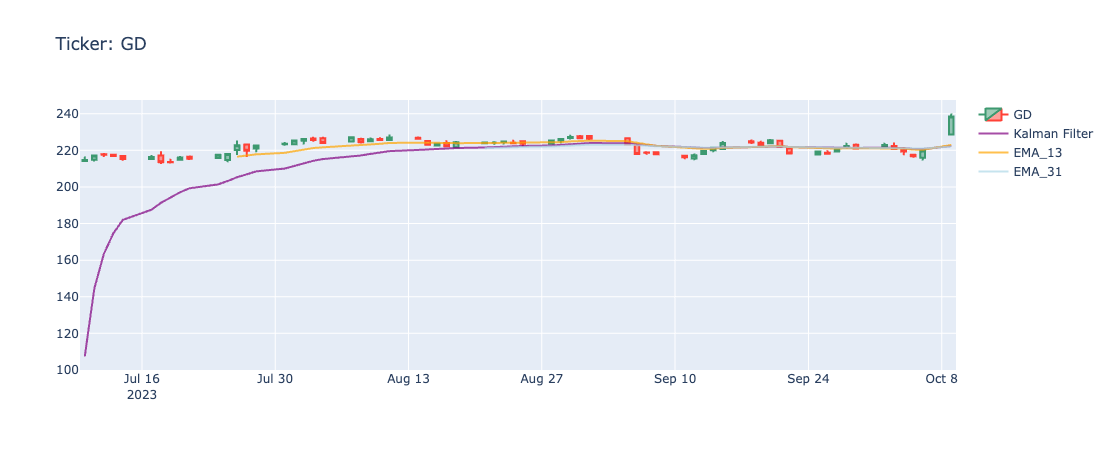

Ticker: CRK

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 12.289999961853027

Ichimoku 9-Day Forecast: 11.305000066757202

Ichimoku 26-Day Forecast: 11.699999809265137

Choppiness (%): 41.57

RSI: 62.27650909470715

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

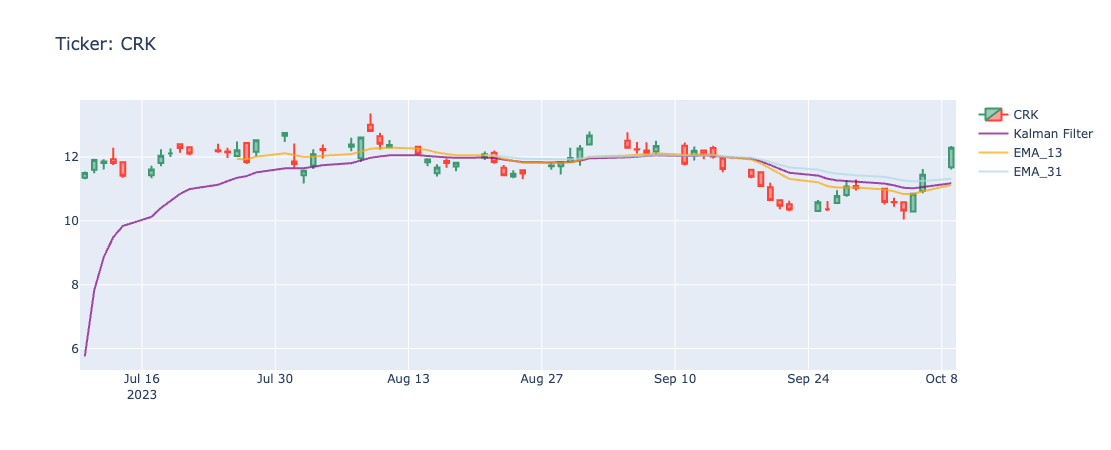

Ticker: MRCY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 39.0

Ichimoku 9-Day Forecast: 37.38000011444092

Ichimoku 26-Day Forecast: 36.60499954223633

Choppiness (%): 50.04

RSI: 60.691671882491484

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

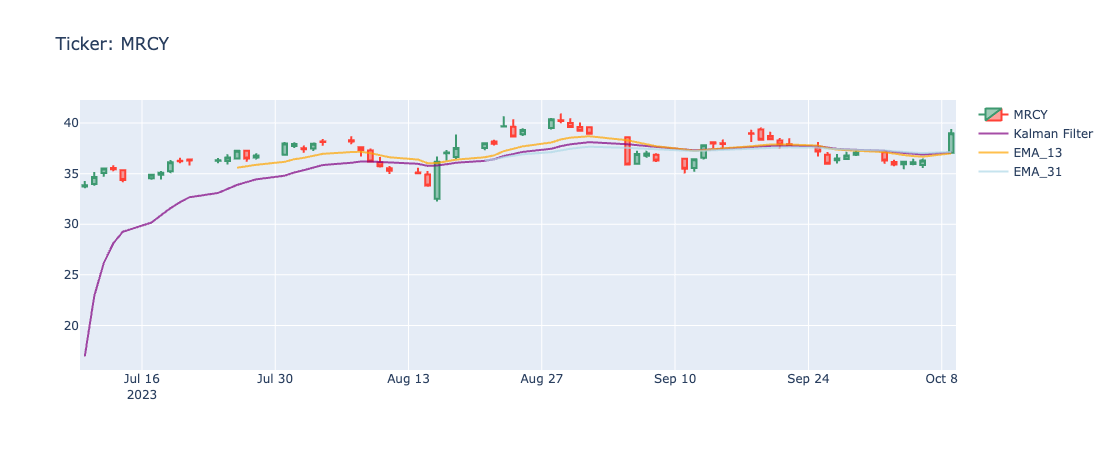

Ticker: HPK

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 15.84000015258789

Ichimoku 9-Day Forecast: 16.15000009536743

Ichimoku 26-Day Forecast: 15.569999694824219

Choppiness (%): 46.24

RSI: 51.01737586243116

Archer MA Trending: False

EMA14 > Kalman: True

Low > Kalman: False

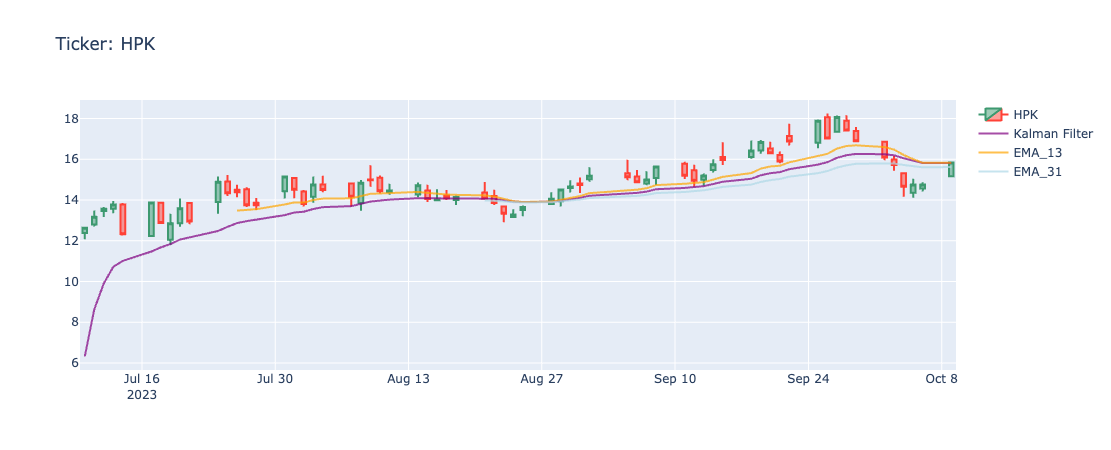

Ticker: GETY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 6.28000020980835

Ichimoku 9-Day Forecast: 5.897500038146973

Ichimoku 26-Day Forecast: 5.5

Choppiness (%): 46.67

RSI: 58.215236819813136

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

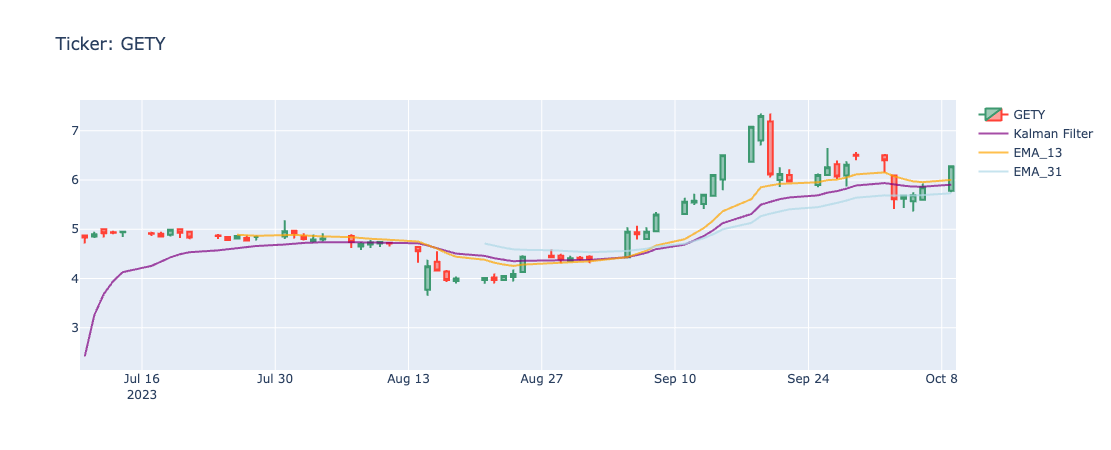

Ticker: PTEN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 13.220000267028809

Ichimoku 9-Day Forecast: 13.725000143051147

Ichimoku 26-Day Forecast: 13.950000286102295

Choppiness (%): 36.21

RSI: 41.718950942584485

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

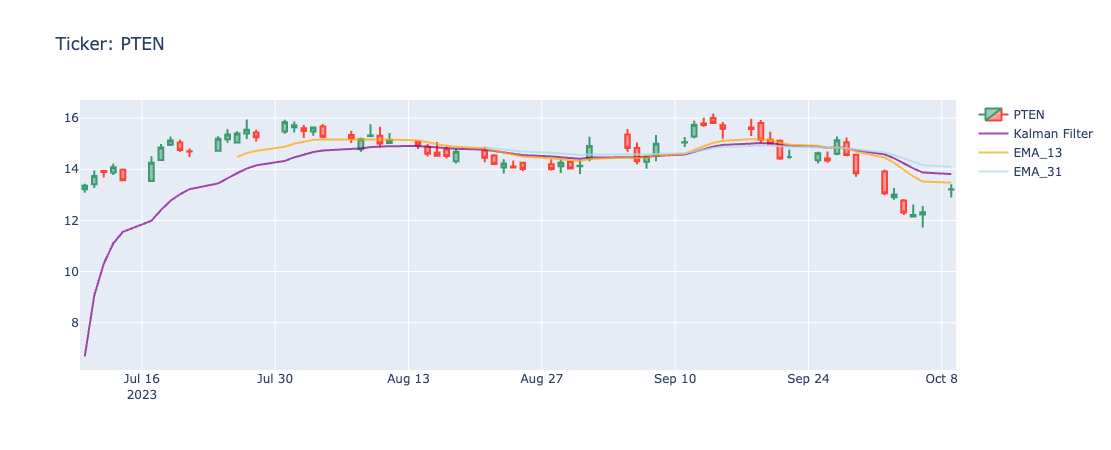

Ticker: AU

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 17.100000381469727

Ichimoku 9-Day Forecast: 16.5

Ichimoku 26-Day Forecast: 18.65499973297119

Choppiness (%): 38.90

RSI: 51.620353510217036

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

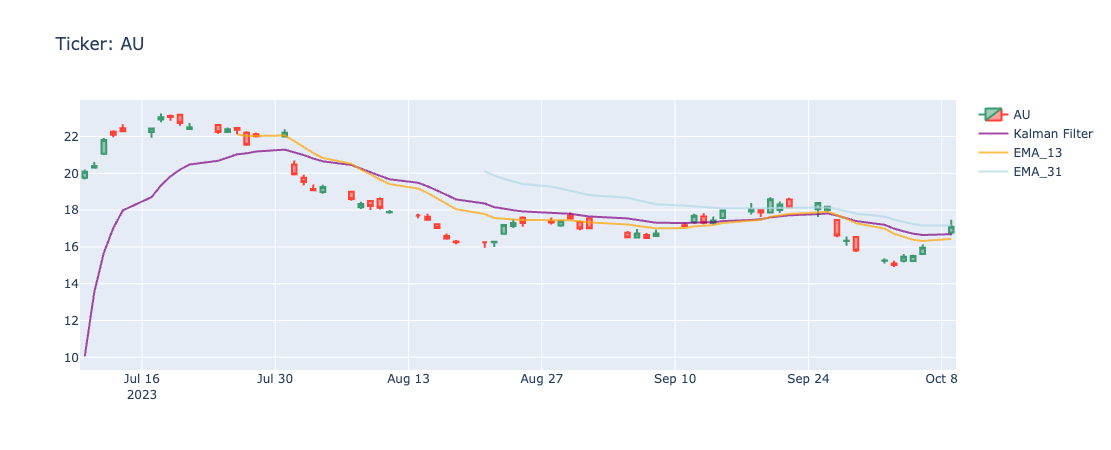

Ticker: MTDR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 59.349998474121094

Ichimoku 9-Day Forecast: 58.41499996185303

Ichimoku 26-Day Forecast: 58.93000030517578

Choppiness (%): 49.01

RSI: 51.81711070475017

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

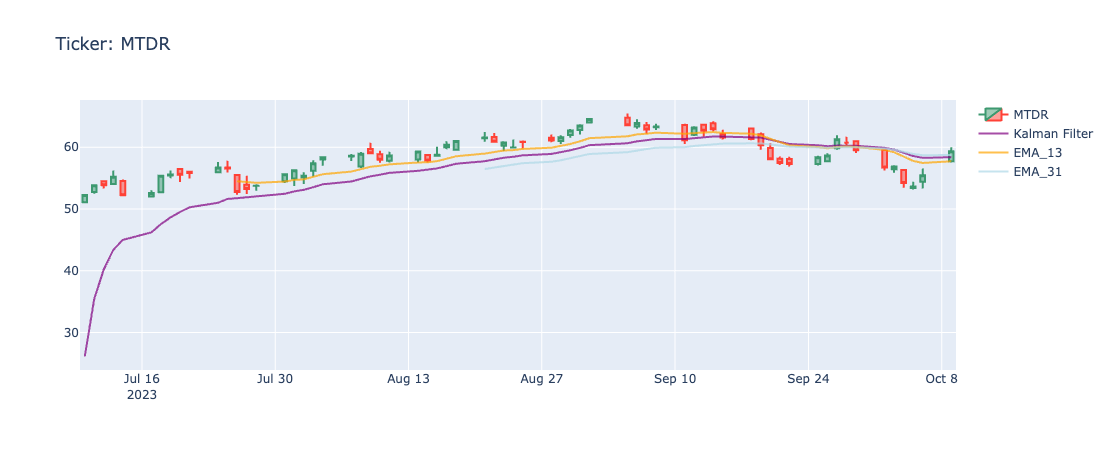

Ticker: MOS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 35.97999954223633

Ichimoku 9-Day Forecast: 35.84749889373779

Ichimoku 26-Day Forecast: 37.989999771118164

Choppiness (%): 35.26

RSI: 48.17164738968953

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

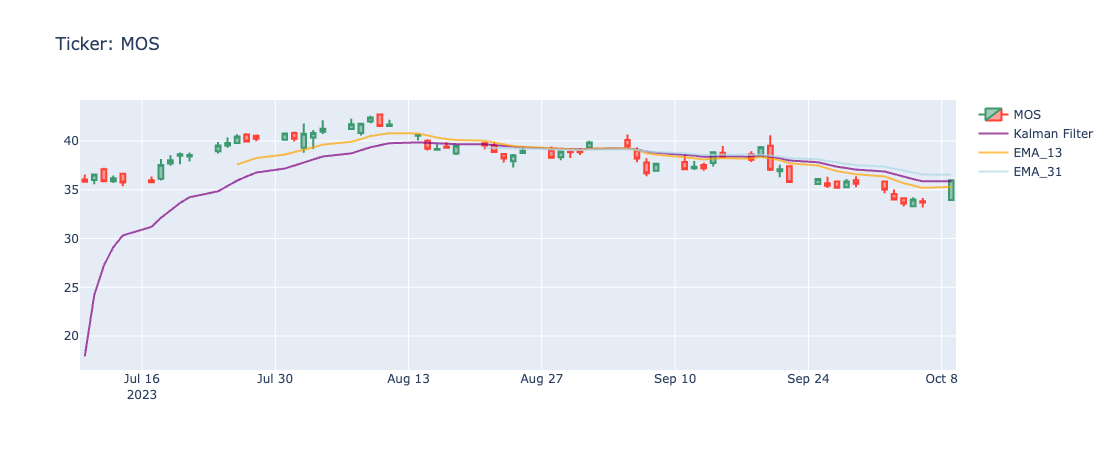

Ticker: MEOH

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 45.029998779296875

Ichimoku 9-Day Forecast: 43.260000228881836

Ichimoku 26-Day Forecast: 43.364999771118164

Choppiness (%): 56.63

RSI: 58.3861136455436

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

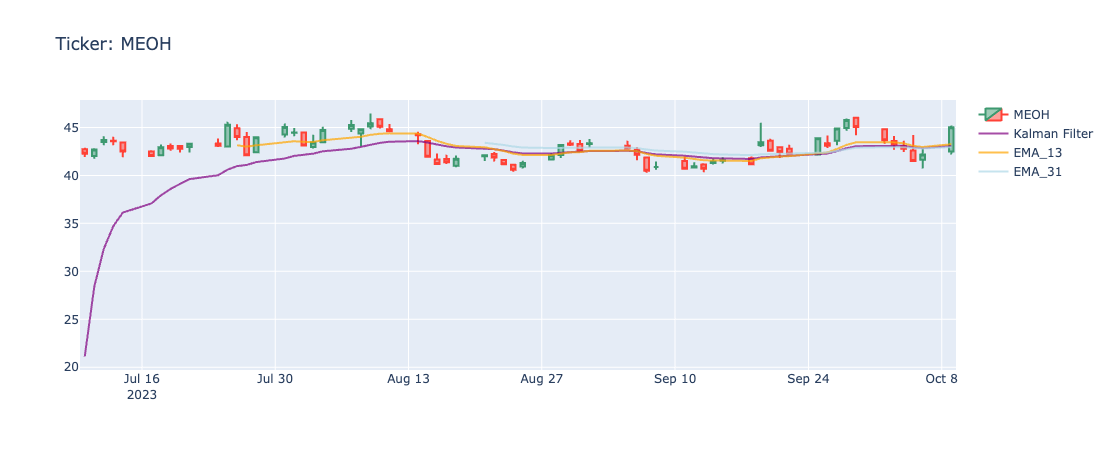

Ticker: HAL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 41.310001373291016

Ichimoku 9-Day Forecast: 40.322500228881836

Ichimoku 26-Day Forecast: 40.420000076293945

Choppiness (%): 49.68

RSI: 55.69833573001966

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

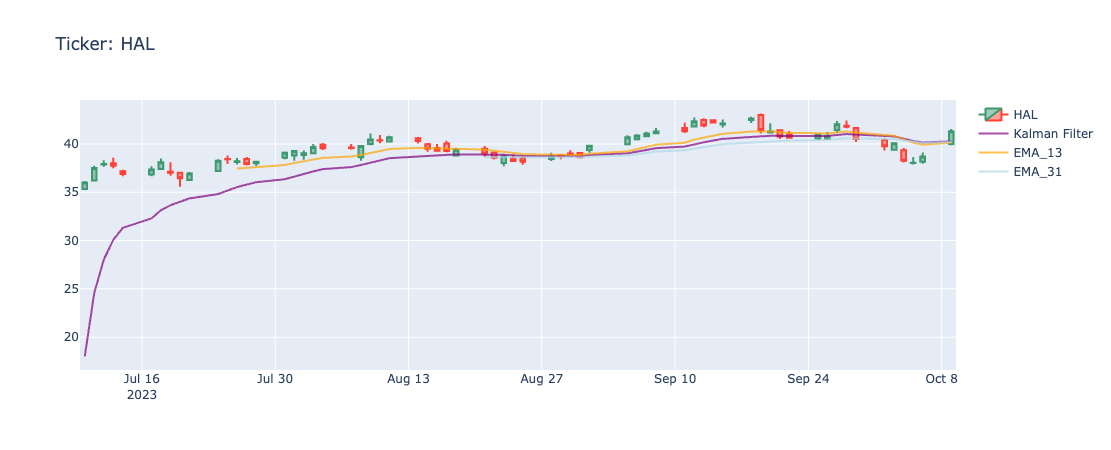

Ticker: AR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 27.3799991607666

Ichimoku 9-Day Forecast: 25.730000019073486

Ichimoku 26-Day Forecast: 26.600000381469727

Choppiness (%): 48.88

RSI: 61.64591585963685

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

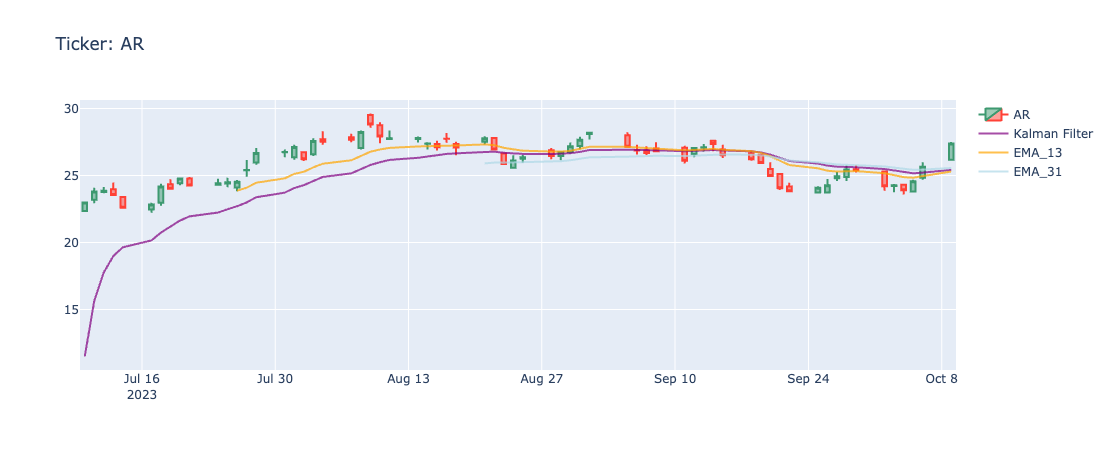

Ticker: MRO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 26.219999313354492

Ichimoku 9-Day Forecast: 25.84000015258789

Ichimoku 26-Day Forecast: 25.84000015258789

Choppiness (%): 46.97

RSI: 51.24736555363987

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

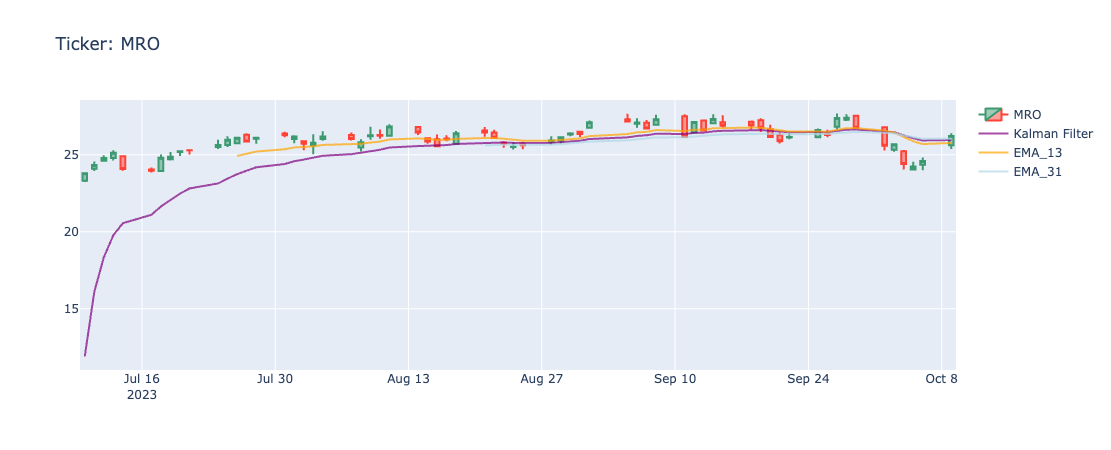

Ticker: ESTE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 20.350000381469727

Ichimoku 9-Day Forecast: 19.55500030517578

Ichimoku 26-Day Forecast: 18.549999713897705

Choppiness (%): 53.41

RSI: 59.10032149698514

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

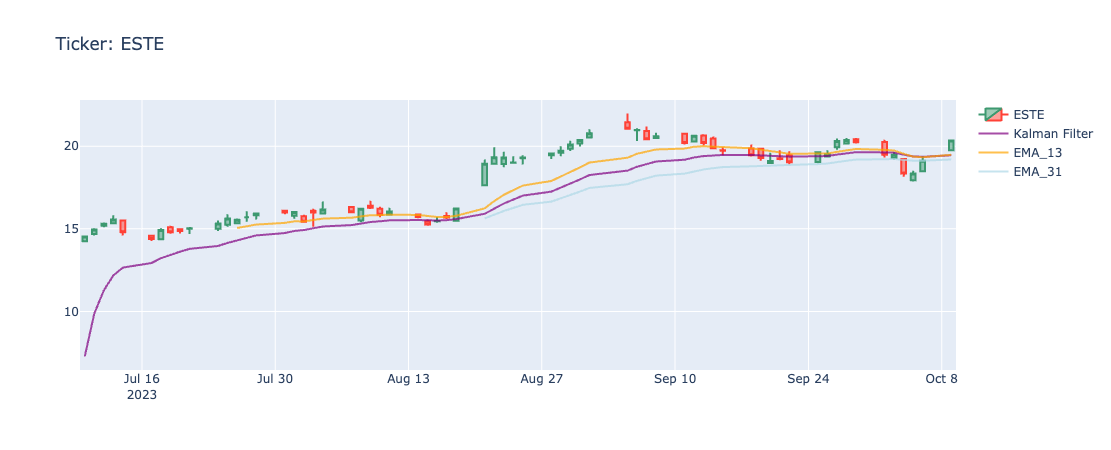

Ticker: HP

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 41.0099983215332

Ichimoku 9-Day Forecast: 41.672499656677246

Ichimoku 26-Day Forecast: 42.04999923706055

Choppiness (%): 40.43

RSI: 46.579736979780186

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

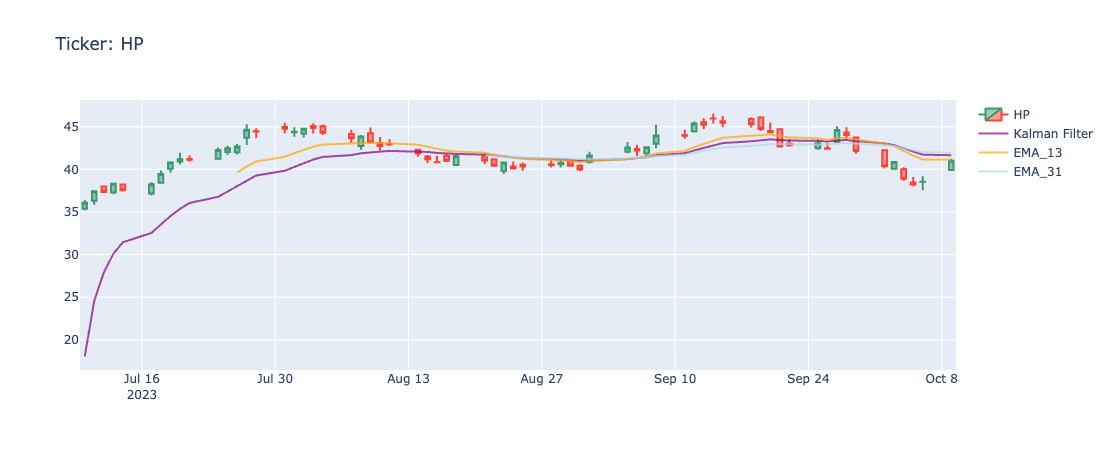

Ticker: OVV

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 48.43000030517578

Ichimoku 9-Day Forecast: 46.204999923706055

Ichimoku 26-Day Forecast: 46.295000076293945

Choppiness (%): 51.83

RSI: 57.25538357815734

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

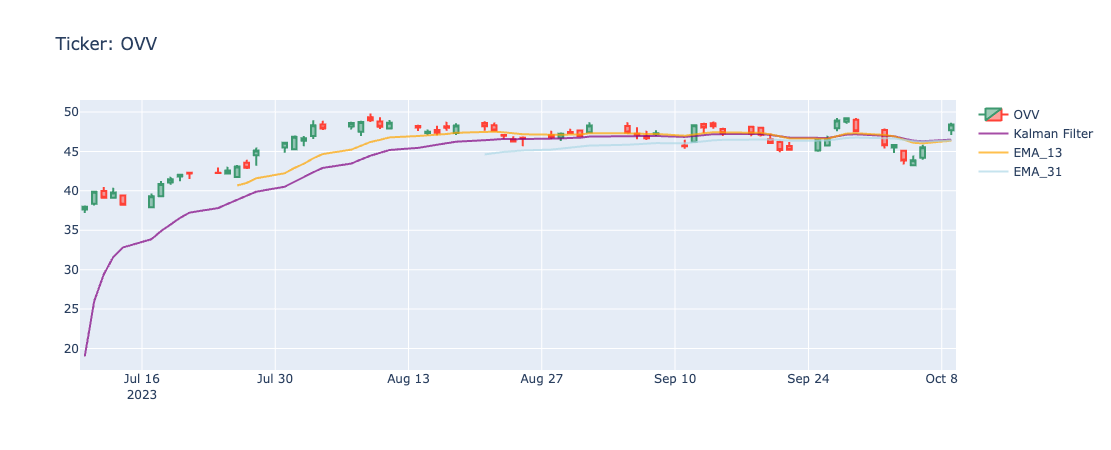

Ticker: CF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 86.02999877929688

Ichimoku 9-Day Forecast: 83.28250122070312

Ichimoku 26-Day Forecast: 80.1500015258789

Choppiness (%): 56.62

RSI: 59.96948921258368

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

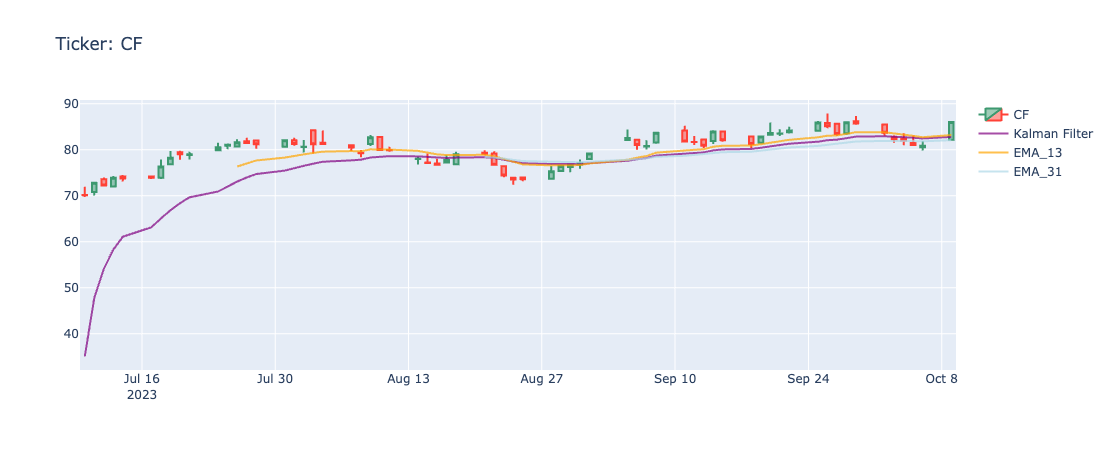

In [4]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        calculate_symbol(v)
        print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
        print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
        print('\n\nClose:',calculate_symbol(v)[1])
        print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
        print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
        print('Choppiness (%):',calculate_symbol(v)[4])
        print('RSI:',calculate_symbol(v)[5])
        print('Archer MA Trending:',calculate_symbol(v)[6])
        print('EMA14 > Kalman:',calculate_symbol(v)[7])
        print('Low > Kalman:',calculate_symbol(v)[10])
        plot(v.tail(90),i)
    except:pass

In [5]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [6]:
# Archer Moving Averages Trends
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb
# https://www.tradingview.com/script/Z2mq63fE-Trade-Archer-Moving-Averages-v1-4F/

In [ ]:
# en fin